In [ ]:
# Install the libraries
# !pip install transformers datasets peft torch accelerate evaluate
!pip install -q transformers datasets peft torch accelerate evaluate # '-q' flag to quietly install the packages without showing the output logs

In [ ]:
import torch
import random
import numpy as np
import pandas as pd
import gc

# Import Hugging Face libraries
import evaluate
from datasets import load_dataset, Dataset, DatasetDict, IterableDataset, IterableDatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, EvalPrediction
from peft import LoraConfig, TaskType, get_peft_model

In [ ]:
# Import the Python types
from typing import List, Dict, Any, Tuple, cast, Optional

from dataclasses import dataclass, asdict

Constants

In [ ]:
SEED = 42
TRAIN_SAMPLE_SIZE = 3000
TOTAL_TRIALS = 20
NUM_LABELS = 6
MAX_LENGTH = 128
MODEL = "distilbert-base-uncased"

Hyperparameters

In [ ]:
# Search Space (Discrete Options)

LR_MIN, LR_MAX = 1e-5, 2e-4

WARMUP_OPTIONS = [0.0, 0.06, 0.1]

RANK_OPTIONS = [2, 4, 8, 16, 24]

ALPHA_OPTIONS = [8, 16, 32, 64, 96]

DROPOUT_OPTIONS = [0.0, 0.05, 0.1, 0.2]

TARGET_MODULE_OPTIONS = [
    ["q_lin", "v_lin"],
    ["q_lin", "v_lin", "ffn.lin1", "ffn.lin2"]
]

In [ ]:
def set_global_seed(seed: int):

  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

  # Check if CUDA GPU is available
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


In [ ]:
set_global_seed(SEED)

In [ ]:
class Individual:
  def __init__(self, genes: np.ndarray = None):
    if genes is None:
      self.genes = np.array([
        np.random.uniform(LR_MIN, LR_MAX), # learning rate
        np.random.randint(0, len(WARMUP_OPTIONS)), # warmup ratio
        np.random.randint(0, len(RANK_OPTIONS)), # rank
        np.random.randint(0, len(ALPHA_OPTIONS)), # alpha
        np.random.randint(0, len(DROPOUT_OPTIONS)), # dropout
        np.random.randint(0, len(TARGET_MODULE_OPTIONS)) # target modules
      ], dtype=object)

    else:
      self.genes = genes.copy()

    self.fitness = None

  def decode(self):
    # Continuous gene
    self.learning_rate = self.genes[0]

    warmup_index = np.clip(int(round(self.genes[1])), 0, len(WARMUP_OPTIONS)-1)
    self.warmup_ratio = WARMUP_OPTIONS[warmup_index]

    rank_index = np.clip(int(round(self.genes[2])), 0, len(RANK_OPTIONS)-1)
    self.rank = RANK_OPTIONS[rank_index]

    alpha_index = np.clip(int(round(self.genes[3])), 0, len(ALPHA_OPTIONS)-1)
    self.alpha = ALPHA_OPTIONS[alpha_index]

    dropout_index = np.clip(int(round(self.genes[4])), 0, len(DROPOUT_OPTIONS)-1)
    self.dropout = DROPOUT_OPTIONS[dropout_index]

    target_modules_index = np.clip(int(round(self.genes[5])), 0, len(TARGET_MODULE_OPTIONS)-1)
    self.target_modules = TARGET_MODULE_OPTIONS[target_modules_index]

In [ ]:
# for the parents
def selection(population, num_parents):
  parents = []
  for i in range(num_parents):
    idx1, idx2 = random.sample(range(len(population)), 2)
    if population[idx1].fitness > population[idx2].fitness:
      parents.append(population[idx1])
    else:
      parents.append(population[idx2])
  return parents

# for the children
def crossover(parents, offspring_size):
  offspring = []
  for _ in range(offspring_size):
    parent1, parent2 = random.sample(parents, 2)
    crossover_point = random.randint(1, len(parent1.genes)-1)
    child_genes = np.concatenate([parent1.genes[:crossover_point], parent2.genes[crossover_point:]])
    offspring.append(Individual(child_genes))
  return offspring

# to create new children from current children (with different characteristics)
# to create new children from current children (with different characteristics)
def mutation(individual: Individual):
  if random.random() < 0.1:
    mutation_index = random.randint(0, len(individual.genes)-1)

    if mutation_index == 0:
      individual.genes[mutation_index] = np.random.uniform(LR_MIN, LR_MAX)

    elif mutation_index == 1:
      individual.genes[mutation_index] = np.random.randint(0, len(WARMUP_OPTIONS))

    elif mutation_index == 2:
      individual.genes[mutation_index] = np.random.randint(0, len(RANK_OPTIONS))

    elif mutation_index == 3:
      individual.genes[mutation_index] = np.random.randint(0, len(ALPHA_OPTIONS))

    elif mutation_index == 4:
      individual.genes[mutation_index] = np.random.randint(0, len(DROPOUT_OPTIONS))

    elif mutation_index == 5:
      individual.genes[mutation_index] = np.random.randint(0, len(TARGET_MODULE_OPTIONS))

  return individual # Return the mutated individual, not the list


def blx_alpha_crossover(parent1: Individual, parent2: Individual,
                       min_bounds: np.ndarray, max_bounds: np.ndarray,
                       alpha: float = 0.5) -> Individual:

    child_genes = np.zeros(len(parent1.genes), dtype=object)

    for i in range(len(parent1.genes)):
        g1, g2 = parent1.genes[i], parent2.genes[i]

        if i == 0: # Learning rate is continuous
            g1, g2 = float(g1), float(g2)
            cmin, cmax = min(g1, g2), max(g1, g2)
            interval = cmax - cmin

            child_genes[i] = np.random.uniform(
                cmin - alpha * interval,
                cmax + alpha * interval
            )
        else:
            g1, g2 = float(g1), float(g2)
            cmin, cmax = min(g1, g2), max(g1, g2)
            interval = cmax - cmin

            child_genes[i] = np.random.uniform(
                cmin - alpha * interval,
                cmax + alpha * interval)

    child_genes = np.clip(child_genes.astype(float), min_bounds.astype(float), max_bounds.astype(float))

    for i in range(1, len(child_genes)):
        child_genes[i] = int(round(child_genes[i]))

    return Individual(child_genes.astype(object))



# def fitness_function(individual):
#   individual.decode()
#   learning_rate = individual.learning_rate
#   warmup_ratio = individual.warmup_ratio
#   rank = individual.warmup_ratio
#   alpha = individual.alpha
#   dropout = individual.dropout
#   target_modules = individual.target_modules

#   print





In [ ]:
class DataManager:
  def __init__(self, model_name: str = MODEL):
    self.tokenizer = AutoTokenizer.from_pretrained(model_name)
    self.dataset: Optional[Dict[str, Any]] = None

  def prepare_data(self) -> Dict[str, Any]:
    """
    Loads the dataset and processes it.
    """

    # Check if the dataset is correctly loaded into the instance memory
    if self.dataset is not None:
        return self.dataset

    print("Loading and processing data...")

    # Load full dataset
    full_dataset = cast(DatasetDict, load_dataset("dair-ai/emotion"))

    # Use seed to ensure every run uses the SAME subset of data
    train_subset = full_dataset["train"].shuffle(seed=SEED).select(range(TRAIN_SAMPLE_SIZE))

    # Private helper method for text embeddings
    def _tokenize(examples):
      return self.tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
      )

    tokenized_train_dataset = train_subset.map(_tokenize, batched=True)
    tokenized_validation_dataset = full_dataset["validation"].map(_tokenize, batched=True)

    self.dataset = {
        "train": tokenized_train_dataset,
        "validation": tokenized_validation_dataset,
        "tokenizer": self.tokenizer,
        "num_labels": NUM_LABELS
    }

    print("Data preparation complete.")

    return self.dataset

In [ ]:
data_manager = DataManager()
data_bundle = data_manager.prepare_data()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading and processing data...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Data preparation complete.


# **RCGA-BLX-ALPHA Engine**

In [ ]:
import matplotlib.pyplot as plt

class RCGAExperiment:
    def __init__(self, data_bundle: Dict[str, Any]):
        self.data = data_bundle
        self.results: List[Dict[str, Any]] = []
        self.metric = evaluate.load("accuracy")
        self.trial_counter = 0

        # Bounds for the 6 genes
        self.min_bounds = np.array([LR_MIN, 0, 0, 0, 0, 0])
        # self.max_bounds = np.array([1e-1, 0.1, 24, 96, 0.2, 1.0])
        self.max_bounds = np.array([
            LR_MAX,
            len(WARMUP_OPTIONS) - 0.01,
            len(RANK_OPTIONS) - 0.01,
            len(ALPHA_OPTIONS) - 0.01,
            len(DROPOUT_OPTIONS) - 0.01,
            len(TARGET_MODULE_OPTIONS) - 0.01
        ])


    def _compute_metrics(self, eval_pred: EvalPrediction) -> Dict[str, float]:
        """Calculates accuracy during training."""
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        result = self.metric.compute(predictions=predictions, references=labels)
        return cast(Dict[str, float], result)

    def _cleanup_memory(self):
        """Forcefully clears GPU memory."""
        torch.cuda.empty_cache()
        gc.collect()

    def train_model(self, trial_id: int, individual: Individual, custom_seed: int = None) -> float:

        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL, num_labels=self.data["num_labels"]
        )

        individual.decode()

        lr, warmup_ratio, rank, alpha, dropout, target_modules = (
            individual.learning_rate,
            individual.warmup_ratio,
            individual.rank,
            individual.alpha,
            individual.dropout,
            individual.target_modules
        )

        peft_config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=rank,
            lora_alpha=alpha,
            lora_dropout=dropout,
            target_modules=target_modules
        )

        print(f"Params: LR={lr:.2e}, Rank={rank}, Alpha={alpha}")
        model = get_peft_model(model, peft_config)

        current_seed = SEED + trial_id if custom_seed is None else custom_seed

        args = TrainingArguments(
            output_dir=f"./results/rcga_trial_{trial_id}",
            learning_rate=lr,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=3,
            warmup_ratio=warmup_ratio,
            weight_decay=0.01,
            eval_strategy="epoch",
            save_strategy="no",
            logging_strategy="epoch",
            seed=current_seed,
            report_to="none",
            load_best_model_at_end=False
        )

        data_collator = DataCollatorWithPadding(tokenizer=self.data["tokenizer"])

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=self.data["train"],
            eval_dataset=self.data["validation"],
            data_collator=data_collator,
            compute_metrics=self._compute_metrics
        )

        trainer.train()
        eval_results = trainer.evaluate()

        # Clean up immediately
        del model
        del trainer
        self._cleanup_memory()

        return eval_results["eval_accuracy"]

    def fitness_function(self, individual: Individual) -> float:
        self.trial_counter += 1

        # decoding the individual's genes
        individual.decode()


        try:
            # Train and get accuracy
            accuracy = self.train_model(self.trial_counter, individual)
            print(f"Accuracy: {accuracy:.4%}")
            return accuracy

        except Exception as e:
            print(f"Error in Trial {self.trial_counter}: {e}")
            self._cleanup_memory()
            return 0.0  # Returning worst fitness on failure

    def run_rcga(self, population_size: int = 20, generations: int = 5):
        print(f"Starting RCGA: {population_size} individuals, {generations} generations.")

        # 1. Initialization
        population = [Individual() for _ in range(population_size)]

        best_individual = None
        best_fitness = -float('inf')

        for gen in range(generations):
            print(f"\n{'='*50}")
            print(f"GENERATION {gen + 1}/{generations}")
            print(f"{'='*50}")

            # 2. Evaluation
            for i, individual in enumerate(population):
                print(f"\n[Gen {gen+1}, Individual {i+1}/{population_size}]")
                individual.fitness = self.fitness_function(individual)

                # Track best
                if individual.fitness > best_fitness:
                    best_fitness = individual.fitness
                    best_individual = Individual(individual.genes.copy())
                    print(f"NEW BEST FITNESS: {best_fitness:.4%}")

                # Log result
                individual.decode()
                record = {
                    "generation": gen + 1,
                    "trial_id": self.trial_counter,
                    "accuracy": individual.fitness,
                    "learning_rate": individual.learning_rate,
                    "warmup_ratio": individual.warmup_ratio,
                    "rank": individual.rank,
                    "alpha": individual.alpha,
                    "dropout": individual.dropout,
                    "target_modules": str(individual.target_modules)
                }
                self.results.append(record)

            # Stop if last generation
            if gen == generations - 1:
                break

            # 3. Selection
            num_parents = population_size // 2
            parents = selection(population, num_parents)

            # 4. Crossover + 5. Mutation
            offspring = []
            offspring.append(Individual(best_individual.genes.copy()))  # Elitism

            while len(offspring) < population_size:
                parent1, parent2 = random.sample(parents, 2)
                child = blx_alpha_crossover(parent1, parent2, self.min_bounds, self.max_bounds, alpha=0.5)
                mutation(child)
                offspring.append(child)

            # 6. Replace population
            population = offspring

        print(f"\n{'='*50}")
        print("RCGA OPTIMIZATION COMPLETE")
        print(f"{'='*50}")
        print(f"Best Fitness: {best_fitness:.4%}")

        return best_individual, best_fitness

    def plot_generation_vs_accuracy(self, filename: str = "generation_vs_accuracy.png"):
          """Plots the best, average, and worst accuracy per generation."""
          if not self.results:
              print("No results to plot.")
              return

          df = pd.DataFrame(self.results)

          # Aggregate statistics per generation
          gen_stats = df.groupby('generation')['accuracy'].agg(['max', 'mean', 'min']).reset_index()

          plt.figure(figsize=(10, 6))
          plt.plot(gen_stats['generation'], gen_stats['max'], label='Best Accuracy', marker='o')
          plt.plot(gen_stats['generation'], gen_stats['mean'], label='Average Accuracy', marker='s')
          plt.plot(gen_stats['generation'], gen_stats['min'], label='Worst Accuracy', marker='^')

          plt.title('RCGA Performance: Accuracy vs. Generation')
          plt.xlabel('Generation')
          plt.ylabel('Accuracy')
          plt.legend()
          plt.grid(True)
          plt.tight_layout()
          plt.savefig(filename)
          plt.show()
          print(f"Plot saved to {filename}")

    def plot_top5_reevaluation(self, final_results: List[Dict[str, Any]], filename: str = "top5_reevaluation_summary.png"):
        """Plots the mean accuracy and standard deviation for the top 5 re-evaluated solutions."""

        ranks = [f"Rank {r['rank']}" for r in final_results]
        means = [r['mean_accuracy'] for r in final_results]
        stds = [r['std_accuracy'] for r in final_results]

        plt.figure(figsize=(12, 7))
        bars = plt.bar(ranks, means, yerr=stds, capsize=5, color='skyblue', ecolor='red')

        plt.title('Top 5 Solutions Re-evaluation (Mean Accuracy $\\pm$ Std. Deviation)')
        plt.xlabel('Solution Rank')
        plt.ylabel('Mean Accuracy')
        plt.ylim(min(means) - max(stds) * 1.5, max(means) + max(stds) * 1.5) # Dynamic y-limit
        plt.grid(axis='y', linestyle='--')

        # Add text labels for mean and std
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2., height + 0.01,
                     f"{mean:.4f}\\n$\\pm{std:.4f}$",
                     ha='center', va='bottom', fontsize=9)

        plt.tight_layout()
        plt.savefig(filename)
        plt.show()
        print(f"Plot saved to {filename}")

    def save_results(self, filename: str = "rcga_results.csv"):
        """Saves results to CSV and prints summary"""
        if not self.results:
            print("No results to save.")
            return

        df = pd.DataFrame(self.results)
        df.to_csv(filename, index=False)
        print(f"\nResults saved to {filename}")

        # Print stats
        best_run = df.loc[df['accuracy'].idxmax()]
        print("\n" + "="*40)
        print("TOP RESULT:")
        print("="*40)
        print(f"Accuracy: {best_run['accuracy']:.4%}")
        print(f"Generation: {int(best_run['generation'])}")
        print(f"Rank: {int(best_run['rank'])}, Alpha: {int(best_run['alpha'])}")
        print(f"LR: {best_run['learning_rate']:.2e}")
        print(f"Warmup: {best_run['warmup_ratio']}")
        print(f"Dropout: {best_run['dropout']}")

        self.plot_generation_vs_accuracy()

    def evaluate_top_solutions_with_seeds(self, num_top: int = 5, num_seeds: int = 3,
                                            results_filename: str = "top5_reeval_results.csv"):
          if not self.results:
              print("No results available. Run the experiment first.")
              return

          print(f"\n{'='*60}")
          print(f"EVALUATING TOP {num_top} SOLUTIONS WITH {num_seeds} DIFFERENT SEEDS")
          print(f"{'='*60}")

          # Convert results to DataFrame and get top solutions
          df = pd.DataFrame(self.results)
          df_sorted = df.sort_values('accuracy', ascending=False).head(num_top)

          final_results = []
          detailed_results = []  # For CSV export

          for rank, (idx, row) in enumerate(df_sorted.iterrows(), 1):
              individual = Individual()
              individual.learning_rate = row['learning_rate']
              individual.warmup_ratio = row['warmup_ratio']
              individual.rank = row['rank']
              individual.alpha = row['alpha']
              individual.dropout = row['dropout']

              # parsing target_modules back from string
              target_modules_str = row['target_modules']
              if 'ffn' in target_modules_str:
                  individual.target_modules = ["q_lin", "v_lin", "ffn.lin1", "ffn.lin2"]
              else:
                  individual.target_modules = ["q_lin", "v_lin"]

              original_accuracy = row['accuracy']

              print(f"\n{'='*60}")
              print(f"RANK {rank} - Original Accuracy: {original_accuracy:.4%}")
              print(f"{'='*60}")
              print(f"Params: LR={individual.learning_rate:.2e}, "
                    f"Warmup={individual.warmup_ratio}, Rank={individual.rank}")
              print(f"        Alpha={individual.alpha}, Dropout={individual.dropout}, "
                    f"Modules={len(individual.target_modules)}")
              print(f"\nRunning {num_seeds} evaluations with different seeds...")

              seed_accuracies = []

              for seed_run in range(num_seeds):
                  # high trial_id offset to avoid collision with optimization trials
                  trial_id = 10000 + (rank * 100) + seed_run

                  # using different seed for each run
                  current_seed = SEED + trial_id

                  print(f"  Seed run {seed_run + 1}/{num_seeds} (seed={current_seed})...", end=" ")

                  try:
                      accuracy = self.train_model(trial_id, individual, custom_seed=current_seed)
                      seed_accuracies.append(accuracy)
                      print(f"Accuracy: {accuracy:.4%}")

                      # Save detailed result
                      detailed_results.append({
                          'rank': rank,
                          'seed_run': seed_run + 1,
                          'seed': current_seed,
                          'accuracy': accuracy,
                          'learning_rate': individual.learning_rate,
                          'warmup_ratio': individual.warmup_ratio,
                          'rank_param': individual.rank,
                          'alpha': individual.alpha,
                          'dropout': individual.dropout,
                          'target_modules': str(individual.target_modules),
                          'original_accuracy': original_accuracy
                      })

                  except Exception as e:
                      print(f"ERROR: {e}")
                      self._cleanup_memory()
                      seed_accuracies.append(0.0)

              # calculating statistics
              mean_acc = np.mean(seed_accuracies)
              std_acc = np.std(seed_accuracies)
              min_acc = np.min(seed_accuracies)
              max_acc = np.max(seed_accuracies)

              print(f"\n  Results: {mean_acc:.4%} \u00b1 {std_acc:.4%}")
              print(f"  Range: [{min_acc:.4%}, {max_acc:.4%}]")
              print(f"  Individual runs: {[f'{acc:.4%}' for acc in seed_accuracies]}")

              final_results.append({
                  'rank': rank,
                  'learning_rate': individual.learning_rate,
                  'warmup_ratio': individual.warmup_ratio,
                  'rank_param': individual.rank,
                  'alpha': individual.alpha,
                  'dropout': individual.dropout,
                  'target_modules': str(individual.target_modules),
                  'original_accuracy': original_accuracy,
                  'mean_accuracy': mean_acc,
                  'std_accuracy': std_acc,
                  'min_accuracy': min_acc,
                  'max_accuracy': max_acc,
                  'seed_accuracies': seed_accuracies
              })

          # saving detailed results to CSV
          if detailed_results:
              df_detailed = pd.DataFrame(detailed_results)
              df_detailed.to_csv(results_filename, index=False)
              print(f"\n{'='*60}")
              print(f"Detailed results saved to {results_filename}")

          # Print final summary
          print(f"\n{'='*60}")
          print(f"FINAL SUMMARY - TOP {num_top} SOLUTIONS")
          print(f"{'='*60}")

          for result in final_results:
              print(f"\n{result['rank']}. Mean Accuracy: {result['mean_accuracy']:.4%} \u00b1 {result['std_accuracy']:.4%}")
              print(f"   Original: {result['original_accuracy']:.4%}, "
                    f"Range: [{result['min_accuracy']:.4%}, {result['max_accuracy']:.4%}]")
              print(f"   LR: {result['learning_rate']:.2e}, Warmup: {result['warmup_ratio']}, "
                    f"Rank: {result['rank_param']}")
              print(f"   Alpha: {result['alpha']}, Dropout: {result['dropout']}, "
                    f"Modules: {result['target_modules']}")
              runs_str = [f"{acc:.4%}" for acc in result['seed_accuracies']]
              print(f"   Runs: {runs_str}")

          # identifying most robust solution (highest mean - std)
          best_robust_idx = max(range(len(final_results)),
                                key=lambda i: final_results[i]['mean_accuracy'] - final_results[i]['std_accuracy'])

          print(f"\n{'='*60}")
          print("MOST ROBUST SOLUTION (Mean - Std):")
          print(f"{'='*60}")
          robust_result = final_results[best_robust_idx]
          print(f"Rank {robust_result['rank']}: {robust_result['mean_accuracy']:.4%} \u00b1 {robust_result['std_accuracy']:.4%}")
          print(f"Robustness Score: {robust_result['mean_accuracy'] - robust_result['std_accuracy']:.4%}")

          return final_results

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting RCGA: 20 individuals, 5 generations.

GENERATION 1/5

[Gen 1, Individual 1/20]
Params: LR=8.12e-05, Rank=8, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.311500,0.979289,0.666500
2,0.841300,0.757225,0.713500
3,0.696200,0.708165,0.741000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 74.1000%
NEW BEST FITNESS: 74.1000%

[Gen 1, Individual 2/20]
Params: LR=9.47e-05, Rank=8, Alpha=32


Epoch,Training Loss,Validation Loss,Accuracy
1,1.393700,1.021493,0.642000
2,0.876500,0.781370,0.701000
3,0.724900,0.731417,0.728000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 72.8000%

[Gen 1, Individual 3/20]
Params: LR=1.24e-04, Rank=24, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.281800,0.847655,0.671000
2,0.683500,0.579138,0.785000
3,0.504700,0.521982,0.811500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.1500%
NEW BEST FITNESS: 81.1500%

[Gen 1, Individual 4/20]
Params: LR=1.88e-04, Rank=16, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.029800,0.553367,0.807000
2,0.382500,0.406470,0.868500
3,0.209600,0.342314,0.894000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.4000%
NEW BEST FITNESS: 89.4000%

[Gen 1, Individual 5/20]
Params: LR=1.26e-04, Rank=16, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.380000,1.080031,0.619500
2,0.926900,0.827791,0.689500
3,0.771500,0.774076,0.704000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 70.4000%

[Gen 1, Individual 6/20]
Params: LR=1.26e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.249400,0.843955,0.677000
2,0.706000,0.638504,0.769500
3,0.556400,0.591334,0.783000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 78.3000%

[Gen 1, Individual 7/20]
Params: LR=9.67e-05, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.248800,0.847382,0.684500
2,0.642800,0.544071,0.799000
3,0.450400,0.483772,0.828500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 82.8500%

[Gen 1, Individual 8/20]
Params: LR=1.23e-04, Rank=24, Alpha=32


Epoch,Training Loss,Validation Loss,Accuracy
1,1.335000,0.916054,0.657000
2,0.768600,0.690883,0.741500
3,0.624400,0.636406,0.771000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 77.1000%

[Gen 1, Individual 9/20]
Params: LR=9.56e-05, Rank=16, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.376600,1.037096,0.621500
2,0.877200,0.769591,0.697500
3,0.705000,0.712628,0.739000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 73.9000%

[Gen 1, Individual 10/20]
Params: LR=1.64e-04, Rank=4, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.028500,0.637833,0.771500
2,0.458500,0.406579,0.867500
3,0.282000,0.373218,0.883500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.3500%

[Gen 1, Individual 11/20]
Params: LR=5.58e-05, Rank=16, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.425400,1.077483,0.594500
2,0.944700,0.861556,0.685500
3,0.792100,0.806813,0.698500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 69.8500%

[Gen 1, Individual 12/20]
Params: LR=4.29e-05, Rank=16, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.483300,1.236084,0.544500
2,1.126500,1.046234,0.619000
3,0.990400,0.991346,0.645500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 64.5500%

[Gen 1, Individual 13/20]
Params: LR=6.92e-05, Rank=4, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.380600,1.079783,0.602500
2,0.935900,0.864192,0.685000
3,0.795100,0.802413,0.700500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 70.0500%

[Gen 1, Individual 14/20]
Params: LR=1.94e-04, Rank=16, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.138800,0.694073,0.758000
2,0.539100,0.466547,0.841500
3,0.382400,0.426716,0.855500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.5500%

[Gen 1, Individual 15/20]
Params: LR=1.86e-04, Rank=16, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.252500,0.868451,0.687500
2,0.647500,0.552363,0.795500
3,0.459600,0.497809,0.830000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 83.0000%

[Gen 1, Individual 16/20]
Params: LR=1.70e-04, Rank=4, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.025300,0.612139,0.775000
2,0.454200,0.394472,0.865500
3,0.281500,0.367705,0.889000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.9000%

[Gen 1, Individual 17/20]
Params: LR=1.93e-04, Rank=2, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.127600,0.730990,0.723500
2,0.617500,0.554486,0.800500
3,0.478200,0.522103,0.820000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 82.0000%

[Gen 1, Individual 18/20]
Params: LR=2.42e-05, Rank=2, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.645400,1.524814,0.479000
2,1.404800,1.302841,0.530500
3,1.269500,1.253876,0.537500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 53.7500%

[Gen 1, Individual 19/20]
Params: LR=1.10e-05, Rank=8, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.692100,1.600680,0.352000
2,1.570700,1.558255,0.361500
3,1.544400,1.550390,0.392000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 39.2000%

[Gen 1, Individual 20/20]
Params: LR=1.60e-04, Rank=24, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.209900,0.745120,0.720000
2,0.581200,0.504256,0.818500
3,0.424100,0.462784,0.836000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 83.6000%

GENERATION 2/5

[Gen 2, Individual 1/20]
Params: LR=1.88e-04, Rank=16, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.010300,0.558490,0.805500
2,0.410000,0.391958,0.875000
3,0.245800,0.351537,0.886500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.6500%

[Gen 2, Individual 2/20]
Params: LR=1.10e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.251200,0.932223,0.660500
2,0.778900,0.695981,0.740000
3,0.624900,0.647926,0.765500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 76.5500%

[Gen 2, Individual 3/20]
Params: LR=1.25e-04, Rank=16, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.230500,0.811667,0.702000
2,0.683700,0.617253,0.790500
3,0.538600,0.572909,0.799000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 79.9000%

[Gen 2, Individual 4/20]
Params: LR=2.00e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.123200,0.690536,0.758500
2,0.571400,0.532317,0.809000
3,0.429500,0.487694,0.827000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 82.7000%

[Gen 2, Individual 5/20]
Params: LR=1.23e-04, Rank=24, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.188400,0.822554,0.699500
2,0.697900,0.642284,0.767500
3,0.554400,0.579345,0.794500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 79.4500%

[Gen 2, Individual 6/20]
Params: LR=2.00e-04, Rank=2, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.052900,0.732421,0.737500
2,0.595100,0.577733,0.798000
3,0.472200,0.526990,0.819500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.9500%

[Gen 2, Individual 7/20]
Params: LR=9.50e-05, Rank=24, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.262500,0.939820,0.671000
2,0.808900,0.729524,0.727000
3,0.660200,0.677065,0.752000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 75.2000%

[Gen 2, Individual 8/20]
Params: LR=1.93e-04, Rank=2, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.123700,0.776950,0.702000
2,0.622700,0.564291,0.799500
3,0.495700,0.521668,0.810000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.0000%

[Gen 2, Individual 9/20]
Params: LR=1.31e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.208700,0.883642,0.687500
2,0.733700,0.658101,0.761000
3,0.591900,0.613080,0.775000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 77.5000%

[Gen 2, Individual 10/20]
Params: LR=1.88e-04, Rank=4, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.204500,0.766948,0.715500
2,0.632200,0.564104,0.797500
3,0.487900,0.517676,0.818500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.8500%

[Gen 2, Individual 11/20]
Params: LR=1.54e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.193800,0.674309,0.744500
2,0.496200,0.439629,0.855500
3,0.298800,0.394243,0.871500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 87.1500%

[Gen 2, Individual 12/20]
Params: LR=1.89e-04, Rank=2, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.057900,0.630316,0.786500
2,0.466400,0.390537,0.874500
3,0.275200,0.354695,0.892000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.2000%

[Gen 2, Individual 13/20]
Params: LR=1.26e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.249800,0.845881,0.684500
2,0.706800,0.642443,0.762500
3,0.561800,0.590806,0.787000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 78.7000%

[Gen 2, Individual 14/20]
Params: LR=1.11e-04, Rank=4, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.132800,0.765408,0.726500
2,0.608600,0.510508,0.834000
3,0.429900,0.453167,0.848500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 84.8500%

[Gen 2, Individual 15/20]
Params: LR=1.06e-04, Rank=4, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.198400,0.742505,0.728000
2,0.582000,0.507844,0.831000
3,0.386400,0.462549,0.852000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.2000%

[Gen 2, Individual 16/20]
Params: LR=1.16e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.152700,0.693704,0.746000
2,0.553700,0.480246,0.839500
3,0.367800,0.436917,0.854000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.4000%

[Gen 2, Individual 17/20]
Params: LR=7.58e-05, Rank=4, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.377500,1.096067,0.598500
2,0.950000,0.864589,0.688000
3,0.790500,0.798156,0.697500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 69.7500%

[Gen 2, Individual 18/20]
Params: LR=1.83e-04, Rank=16, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.264100,0.809070,0.690000
2,0.653500,0.547746,0.809000
3,0.459300,0.490379,0.827000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 82.7000%

[Gen 2, Individual 19/20]
Params: LR=1.16e-04, Rank=2, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.182000,0.789782,0.711000
2,0.593700,0.522774,0.814500
3,0.404400,0.452649,0.842500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 84.2500%

[Gen 2, Individual 20/20]
Params: LR=1.64e-04, Rank=4, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.162900,0.798095,0.711500
2,0.680400,0.611993,0.779000
3,0.542500,0.558984,0.797500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 79.7500%

GENERATION 3/5

[Gen 3, Individual 1/20]
Params: LR=1.88e-04, Rank=16, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.013400,0.529648,0.827000
2,0.379300,0.348416,0.884000
3,0.227100,0.320603,0.890500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.0500%

[Gen 3, Individual 2/20]
Params: LR=1.16e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.175800,0.718964,0.725000
2,0.575900,0.499646,0.816000
3,0.372000,0.440142,0.845000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 84.5000%

[Gen 3, Individual 3/20]
Params: LR=1.90e-04, Rank=4, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.271100,0.809409,0.684000
2,0.659200,0.567612,0.783500
3,0.486500,0.507768,0.810500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.0500%

[Gen 3, Individual 4/20]
Params: LR=1.82e-04, Rank=4, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.061300,0.628612,0.764000
2,0.491500,0.455470,0.848500
3,0.277400,0.358263,0.886000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.6000%

[Gen 3, Individual 5/20]
Params: LR=1.10e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.157100,0.756285,0.717000
2,0.586900,0.492011,0.824000
3,0.396300,0.432296,0.853500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.3500%

[Gen 3, Individual 6/20]
Params: LR=1.87e-04, Rank=16, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.324100,0.929480,0.666500
2,0.769800,0.678609,0.752000
3,0.630600,0.640588,0.772500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 77.2500%

[Gen 3, Individual 7/20]
Params: LR=1.35e-04, Rank=24, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.236500,0.839518,0.687000
2,0.699900,0.623253,0.772000
3,0.553000,0.571969,0.795000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 79.5000%

[Gen 3, Individual 8/20]
Params: LR=1.11e-04, Rank=24, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.175000,0.704350,0.737500
2,0.533500,0.460952,0.840500
3,0.362600,0.418890,0.860500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 86.0500%

[Gen 3, Individual 9/20]
Params: LR=1.99e-04, Rank=2, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.197000,0.826342,0.708500
2,0.707000,0.601097,0.784000
3,0.541300,0.547519,0.804000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 80.4000%

[Gen 3, Individual 10/20]
Params: LR=9.03e-05, Rank=2, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.216000,0.853624,0.702000
2,0.704600,0.616524,0.770500
3,0.518800,0.542987,0.810500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.0500%

[Gen 3, Individual 11/20]
Params: LR=1.20e-04, Rank=24, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.288900,0.855544,0.683000
2,0.718200,0.641082,0.759500
3,0.565900,0.578044,0.790500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 79.0500%

[Gen 3, Individual 12/20]
Params: LR=1.13e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.279500,0.890011,0.683000
2,0.732400,0.661743,0.770000
3,0.595100,0.609461,0.780000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 78.0000%

[Gen 3, Individual 13/20]
Params: LR=1.12e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.199800,0.779490,0.720500
2,0.574100,0.491017,0.836000
3,0.400900,0.443636,0.853500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.3500%

[Gen 3, Individual 14/20]
Params: LR=1.89e-04, Rank=4, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.107800,0.775006,0.714500
2,0.632600,0.608496,0.786000
3,0.503000,0.540014,0.814500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.4500%

[Gen 3, Individual 15/20]
Params: LR=1.94e-04, Rank=16, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.349000,0.953907,0.647500
2,0.769700,0.710860,0.737000
3,0.635100,0.640304,0.763500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 76.3500%

[Gen 3, Individual 16/20]
Params: LR=1.90e-04, Rank=24, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.155400,0.727153,0.727000
2,0.611600,0.581509,0.791000
3,0.449800,0.488671,0.822000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 82.2000%

[Gen 3, Individual 17/20]
Params: LR=2.00e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.048400,0.600684,0.798500
2,0.420300,0.374976,0.877500
3,0.220900,0.330353,0.890000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.0000%

[Gen 3, Individual 18/20]
Params: LR=1.79e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.131500,0.639005,0.761000
2,0.459800,0.392012,0.865000
3,0.273200,0.354283,0.883500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.3500%

[Gen 3, Individual 19/20]
Params: LR=1.94e-04, Rank=16, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.165300,0.702496,0.746000
2,0.538700,0.468426,0.841000
3,0.369700,0.424489,0.852500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.2500%

[Gen 3, Individual 20/20]
Params: LR=1.16e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.163800,0.689884,0.744500
2,0.553600,0.470941,0.835500
3,0.366300,0.420864,0.861500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 86.1500%

GENERATION 4/5

[Gen 4, Individual 1/20]
Params: LR=1.88e-04, Rank=16, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.049900,0.538487,0.808500
2,0.398400,0.359979,0.881500
3,0.213200,0.331050,0.897000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.7000%
NEW BEST FITNESS: 89.7000%

[Gen 4, Individual 2/20]
Params: LR=4.18e-05, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.430000,1.156285,0.575000
2,0.984000,0.888731,0.690000
3,0.819100,0.825451,0.702500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 70.2500%

[Gen 4, Individual 3/20]
Params: LR=1.26e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.171700,0.737286,0.738000
2,0.560100,0.486602,0.827000
3,0.368700,0.422193,0.858000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.8000%

[Gen 4, Individual 4/20]
Params: LR=1.12e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.189600,0.759820,0.719000
2,0.582300,0.498254,0.827000
3,0.401700,0.449202,0.848000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 84.8000%

[Gen 4, Individual 5/20]
Params: LR=2.00e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.008600,0.522089,0.820500
2,0.385700,0.387006,0.876500
3,0.241500,0.339338,0.896000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.6000%

[Gen 4, Individual 6/20]
Params: LR=1.05e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.235300,0.764525,0.719000
2,0.600400,0.485774,0.839000
3,0.393800,0.427832,0.852000


Accuracy: 85.2000%

[Gen 4, Individual 7/20]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Params: LR=2.00e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.051900,0.591741,0.798500
2,0.430200,0.379889,0.879000
3,0.272000,0.350724,0.889500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.9500%

[Gen 4, Individual 8/20]
Params: LR=8.00e-05, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.273700,0.867087,0.692500
2,0.708500,0.602349,0.786000
3,0.522400,0.542818,0.805500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 80.5500%

[Gen 4, Individual 9/20]
Params: LR=1.94e-04, Rank=24, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.078200,0.596430,0.779500
2,0.446300,0.380115,0.870000
3,0.257800,0.360922,0.886500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.6500%

[Gen 4, Individual 10/20]
Params: LR=1.16e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.184400,0.748134,0.734000
2,0.562100,0.477183,0.843500
3,0.377800,0.432485,0.853500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.3500%

[Gen 4, Individual 11/20]
Params: LR=1.12e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.206000,0.766255,0.706500
2,0.574900,0.521124,0.825500
3,0.402000,0.438287,0.849500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 84.9500%

[Gen 4, Individual 12/20]
Params: LR=1.11e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.184100,0.764937,0.735500
2,0.570500,0.492305,0.835000
3,0.382400,0.438821,0.853500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.3500%

[Gen 4, Individual 13/20]
Params: LR=1.37e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.147200,0.676964,0.751500
2,0.516400,0.436928,0.856000
3,0.323700,0.404064,0.873000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 87.3000%

[Gen 4, Individual 14/20]
Params: LR=1.32e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.165700,0.698100,0.738000
2,0.537000,0.464248,0.845000
3,0.357800,0.408151,0.866500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 86.6500%

[Gen 4, Individual 15/20]
Params: LR=1.12e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.210900,0.801123,0.713500
2,0.591700,0.517176,0.797500
3,0.410200,0.447812,0.843500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 84.3500%

[Gen 4, Individual 16/20]
Params: LR=1.12e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.191600,0.739735,0.728500
2,0.556100,0.470067,0.842500
3,0.377700,0.426053,0.858500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.8500%

[Gen 4, Individual 17/20]
Params: LR=1.10e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.152200,0.741473,0.728000
2,0.549900,0.472951,0.849500
3,0.373600,0.427966,0.860500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 86.0500%

[Gen 4, Individual 18/20]
Params: LR=2.00e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.062700,0.580874,0.809000
2,0.434100,0.391977,0.871500
3,0.265500,0.353851,0.888500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.8500%

[Gen 4, Individual 19/20]
Params: LR=1.16e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.222400,0.794729,0.709500
2,0.606500,0.561320,0.789000
3,0.410600,0.447194,0.853000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.3000%

[Gen 4, Individual 20/20]
Params: LR=1.96e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.044500,0.623202,0.772500
2,0.432000,0.401335,0.872000
3,0.229400,0.353344,0.888000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.8000%

GENERATION 5/5

[Gen 5, Individual 1/20]
Params: LR=1.88e-04, Rank=16, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.026900,0.493087,0.824500
2,0.391700,0.379511,0.875500
3,0.217900,0.337846,0.891000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.1000%

[Gen 5, Individual 2/20]
Params: LR=1.95e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.043300,0.568302,0.816000
2,0.407600,0.396410,0.871500
3,0.254700,0.355913,0.892500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.2500%

[Gen 5, Individual 3/20]
Params: LR=1.99e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.020300,0.566167,0.792500
2,0.394500,0.376568,0.876000
3,0.237200,0.328368,0.892000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.2000%

[Gen 5, Individual 4/20]
Params: LR=1.93e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.052600,0.598863,0.780500
2,0.429800,0.415199,0.861000
3,0.263500,0.353550,0.888500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.8500%

[Gen 5, Individual 5/20]
Params: LR=1.69e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.128400,0.609731,0.786500
2,0.471300,0.441723,0.857500
3,0.298300,0.375789,0.880000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.0000%

[Gen 5, Individual 6/20]
Params: LR=1.95e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.033100,0.544794,0.815000
2,0.404100,0.404123,0.864000
3,0.234600,0.355299,0.884000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.4000%

[Gen 5, Individual 7/20]
Params: LR=1.11e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.188200,0.778727,0.719500
2,0.589900,0.511826,0.821500
3,0.416300,0.456671,0.843500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 84.3500%

[Gen 5, Individual 8/20]
Params: LR=1.32e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.188400,0.688459,0.750000
2,0.543800,0.449974,0.843000
3,0.353100,0.406860,0.856500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.6500%

[Gen 5, Individual 9/20]
Params: LR=1.98e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.040300,0.564243,0.789500
2,0.407400,0.396981,0.872000
3,0.257100,0.350318,0.893500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.3500%

[Gen 5, Individual 10/20]
Params: LR=2.00e-04, Rank=24, Alpha=32


Epoch,Training Loss,Validation Loss,Accuracy
1,1.120600,0.600910,0.785000
2,0.475200,0.411698,0.857000
3,0.302200,0.360443,0.880000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.0000%

[Gen 5, Individual 11/20]
Params: LR=1.17e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.198900,0.753274,0.715000
2,0.579000,0.475722,0.828500
3,0.376300,0.426197,0.854000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.4000%

[Gen 5, Individual 12/20]
Params: LR=1.26e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.142600,0.771378,0.710500
2,0.535200,0.479422,0.840000
3,0.340700,0.425564,0.866000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 86.6000%

[Gen 5, Individual 13/20]
Params: LR=1.56e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.141000,0.631466,0.775000
2,0.478100,0.426913,0.855000
3,0.308200,0.373775,0.878500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 87.8500%

[Gen 5, Individual 14/20]
Params: LR=1.37e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.140700,0.684530,0.764000
2,0.473300,0.410362,0.857500
3,0.311200,0.377359,0.872500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 87.2500%

[Gen 5, Individual 15/20]
Params: LR=2.00e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.148600,0.707885,0.737000
2,0.591500,0.539819,0.803000
3,0.455900,0.482486,0.827500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 82.7500%

[Gen 5, Individual 16/20]
Params: LR=1.98e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.029600,0.556586,0.796000
2,0.427900,0.391079,0.875000
3,0.244200,0.340102,0.886000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.6000%

[Gen 5, Individual 17/20]
Params: LR=2.00e-04, Rank=16, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.055200,0.614449,0.788000
2,0.432700,0.400332,0.872000
3,0.268800,0.357712,0.883000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.3000%

[Gen 5, Individual 18/20]
Params: LR=1.97e-04, Rank=24, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.022300,0.573330,0.790500
2,0.440900,0.391926,0.873500
3,0.270700,0.345913,0.889000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.9000%

[Gen 5, Individual 19/20]
Params: LR=1.12e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.204900,0.771156,0.717500
2,0.596100,0.520297,0.815500
3,0.402500,0.429459,0.860000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 86.0000%

[Gen 5, Individual 20/20]
Params: LR=1.32e-04, Rank=8, Alpha=64


Epoch,Training Loss,Validation Loss,Accuracy
1,1.168000,0.767451,0.721500
2,0.549100,0.465721,0.841500
3,0.357100,0.413420,0.859000


Accuracy: 85.9000%

RCGA OPTIMIZATION COMPLETE
Best Fitness: 89.7000%

Results saved to rcga_results.csv

TOP RESULT:
Accuracy: 89.7000%
Generation: 4
Rank: 16, Alpha: 96
LR: 1.88e-04
Warmup: 0.06
Dropout: 0.0


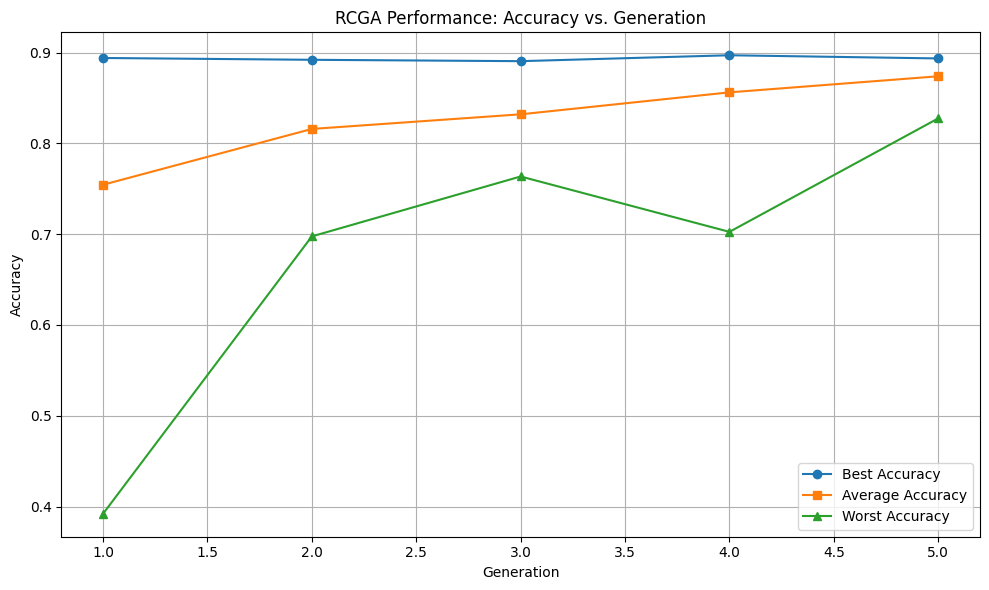

Plot saved to generation_vs_accuracy.png


In [ ]:
# Create the Experiment
experiment = RCGAExperiment(data_bundle)

# Run the experiment
experiment.run_rcga()

# Save the results
experiment.save_results()

# getting top 5 best individuals

Evaluation of top 5 best individuals

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



EVALUATING TOP 5 SOLUTIONS WITH 3 DIFFERENT SEEDS

RANK 1 - Original Accuracy: 89.7000%
Params: LR=1.88e-04, Warmup=0.06, Rank=16
        Alpha=96, Dropout=0.0, Modules=4

Running 3 evaluations with different seeds...
  Seed run 1/3 (seed=10142)... Params: LR=1.81e-04, Rank=8, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.204700,0.827676,0.683000
2,0.654700,0.560147,0.794500
3,0.502400,0.516309,0.814500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.4500%
  Seed run 2/3 (seed=10143)... Params: LR=1.81e-04, Rank=8, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.188900,0.797059,0.713000
2,0.667600,0.582262,0.785500
3,0.495800,0.522756,0.809500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 80.9500%
  Seed run 3/3 (seed=10144)... Params: LR=1.81e-04, Rank=8, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.171900,0.807433,0.706000
2,0.659100,0.572892,0.790000
3,0.504600,0.520929,0.811500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.1500%

  Results: 81.1833% ± 0.2055%
  Range: [80.9500%, 81.4500%]
  Individual runs: ['81.4500%', '80.9500%', '81.1500%']

RANK 2 - Original Accuracy: 89.6000%
Params: LR=2.00e-04, Warmup=0.06, Rank=16
        Alpha=64, Dropout=0.1, Modules=4

Running 3 evaluations with different seeds...
  Seed run 1/3 (seed=10242)... Params: LR=1.93e-04, Rank=16, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.193000,0.811951,0.703000
2,0.703000,0.633691,0.769500
3,0.567500,0.598839,0.780500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 78.0500%
  Seed run 2/3 (seed=10243)... Params: LR=1.93e-04, Rank=16, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.231900,0.856139,0.680500
2,0.731900,0.630639,0.773500
3,0.575200,0.596062,0.784000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 78.4000%
  Seed run 3/3 (seed=10244)... Params: LR=1.93e-04, Rank=16, Alpha=16


Epoch,Training Loss,Validation Loss,Accuracy
1,1.211000,0.815882,0.701500
2,0.706000,0.625152,0.777500
3,0.568400,0.584902,0.791000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 79.1000%

  Results: 78.5167% ± 0.4365%
  Range: [78.0500%, 79.1000%]
  Individual runs: ['78.0500%', '78.4000%', '79.1000%']

RANK 3 - Original Accuracy: 89.4000%
Params: LR=1.88e-04, Warmup=0.06, Rank=16
        Alpha=96, Dropout=0.0, Modules=4

Running 3 evaluations with different seeds...
  Seed run 1/3 (seed=10342)... Params: LR=1.12e-04, Rank=8, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.194100,0.762711,0.719000
2,0.601200,0.535572,0.809500
3,0.385500,0.434573,0.858500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.8500%
  Seed run 2/3 (seed=10343)... Params: LR=1.12e-04, Rank=8, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.132800,0.726307,0.734500
2,0.525500,0.454501,0.848000
3,0.354700,0.409325,0.867500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 86.7500%
  Seed run 3/3 (seed=10344)... Params: LR=1.12e-04, Rank=8, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.170300,0.762112,0.718000
2,0.583300,0.518072,0.812500
3,0.377500,0.440822,0.851000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 85.1000%

  Results: 85.9000% ± 0.6745%
  Range: [85.1000%, 86.7500%]
  Individual runs: ['85.8500%', '86.7500%', '85.1000%']

RANK 4 - Original Accuracy: 89.3500%
Params: LR=1.98e-04, Warmup=0.06, Rank=16
        Alpha=64, Dropout=0.2, Modules=4

Running 3 evaluations with different seeds...
  Seed run 1/3 (seed=10442)... Params: LR=1.93e-04, Rank=4, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.089900,0.593312,0.778000
2,0.433400,0.388959,0.867000
3,0.253500,0.344449,0.888500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.8500%
  Seed run 2/3 (seed=10443)... Params: LR=1.93e-04, Rank=4, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.094500,0.605440,0.786500
2,0.437400,0.397626,0.877500
3,0.226000,0.322758,0.896000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 89.6000%
  Seed run 3/3 (seed=10444)... Params: LR=1.93e-04, Rank=4, Alpha=96


Epoch,Training Loss,Validation Loss,Accuracy
1,1.084900,0.601658,0.790000
2,0.435000,0.387342,0.876000
3,0.245000,0.353199,0.885500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 88.5500%

  Results: 89.0000% ± 0.4416%
  Range: [88.5500%, 89.6000%]
  Individual runs: ['88.8500%', '89.6000%', '88.5500%']

RANK 5 - Original Accuracy: 89.2500%
Params: LR=1.95e-04, Warmup=0.06, Rank=16
        Alpha=64, Dropout=0.05, Modules=4

Running 3 evaluations with different seeds...
  Seed run 1/3 (seed=10542)... Params: LR=1.71e-04, Rank=8, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.258100,0.814274,0.702500
2,0.668600,0.558846,0.799000
3,0.499000,0.507432,0.818000


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 81.8000%
  Seed run 2/3 (seed=10543)... Params: LR=1.71e-04, Rank=8, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.277800,0.848225,0.677000
2,0.680500,0.577427,0.788000
3,0.483800,0.510899,0.820500


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Accuracy: 82.0500%
  Seed run 3/3 (seed=10544)... Params: LR=1.71e-04, Rank=8, Alpha=8


Epoch,Training Loss,Validation Loss,Accuracy
1,1.256600,0.807617,0.702500
2,0.627700,0.563894,0.800500
3,0.489900,0.498603,0.823000


Accuracy: 82.3000%

  Results: 82.0500% ± 0.2041%
  Range: [81.8000%, 82.3000%]
  Individual runs: ['81.8000%', '82.0500%', '82.3000%']

Detailed results saved to top5_re_evaluation_results.csv

FINAL SUMMARY - TOP 5 SOLUTIONS

1. Mean Accuracy: 81.1833% ± 0.2055%
   Original: 89.7000%, Range: [80.9500%, 81.4500%]
   LR: 1.81e-04, Warmup: 0.0, Rank: 8
   Alpha: 8, Dropout: 0.05, Modules: ['q_lin', 'v_lin', 'ffn.lin1', 'ffn.lin2']
   Runs: ['81.4500%', '80.9500%', '81.1500%']

2. Mean Accuracy: 78.5167% ± 0.4365%
   Original: 89.6000%, Range: [78.0500%, 79.1000%]
   LR: 1.93e-04, Warmup: 0.0, Rank: 16
   Alpha: 16, Dropout: 0.1, Modules: ['q_lin', 'v_lin']
   Runs: ['78.0500%', '78.4000%', '79.1000%']

3. Mean Accuracy: 85.9000% ± 0.6745%
   Original: 89.4000%, Range: [85.1000%, 86.7500%]
   LR: 1.12e-04, Warmup: 0.06, Rank: 8
   Alpha: 96, Dropout: 0.1, Modules: ['q_lin', 'v_lin', 'ffn.lin1', 'ffn.lin2']
   Runs: ['85.8500%', '86.7500%', '85.1000%']

4. Mean Accuracy: 89.0000% ± 0.4416

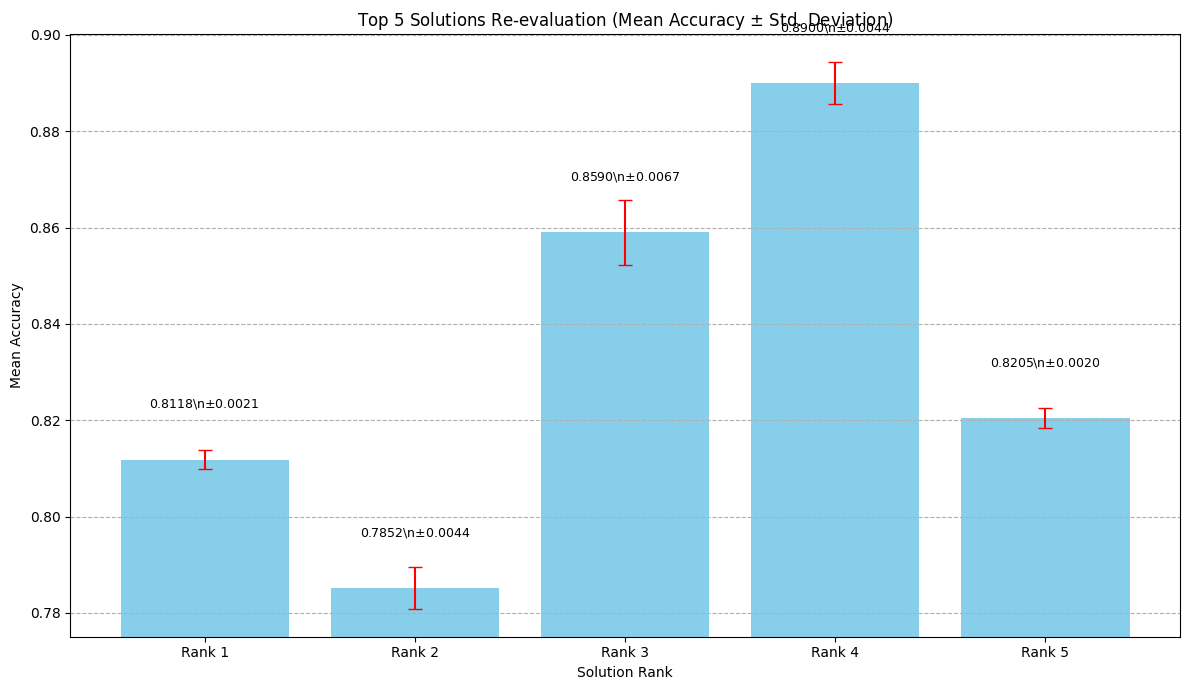

Plot saved to top5_reevaluation_summary.png


In [ ]:
top5_results = experiment.evaluate_top_solutions_with_seeds(
    num_top=5,
    num_seeds=3,
    results_filename="top5_re_evaluation_results.csv"
)

# Step 3: Access results
best_robust = top5_results[0]
print(f"Best robust solution: {best_robust['mean_accuracy']:.4%} ± {best_robust['std_accuracy']:.4%}")

experiment.plot_top5_reevaluation(top5_results)